## Fit ALS Model

This notebook preps, fits and tunes an ALS model.  The objective is to obtain customer and user factors to be used as features in predictive models

In [ ]:
import shutil
import pandas as pd
import numpy as np
import pickle
import boto3
from sagemaker import get_execution_role
from scipy.stats.mstats import winsorize
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import scipy.sparse as sparse
import csv
import ast

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

#!pip install implicit
import implicit

#!pip install hyperopt
from hyperopt import hp, Trials, fmin, tpe

from data_prep.prep_data_for_ALS import *
from train.model import *

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

In [ ]:
role = get_execution_role()
region = boto3.Session().region_name
bucket='udacity-machine-learning-capstone-data'

### Import the customer transaction file

In [3]:
key = 'udacity_capstone_data/all_trans.pkl' 
s3 = boto3.client('s3')
trans_pkl = s3.download_file(bucket, key, './data/all_trans.pkl')

In [4]:
s3 = boto3.resource('s3')
all_cust_trans = pickle.loads(s3.Bucket(bucket).Object(key).get()['Body'].read())
all_cust_trans.head()

,SHOP_WEEK,SHOP_DATE,SHOP_WEEKDAY,SHOP_HOUR,QUANTITY,SPEND,PROD_CODE,PROD_CODE_10,PROD_CODE_20,PROD_CODE_30,PROD_CODE_40,CUST_CODE,CUST_PRICE_SENSITIVITY,CUST_LIFESTAGE,BASKET_ID,BASKET_SIZE,BASKET_PRICE_SENSITIVITY,BASKET_TYPE,BASKET_DOMINANT_MISSION,STORE_CODE,STORE_FORMAT,STORE_REGION
0,200607,20060415,7,19,1,0.93,PRD0900033,CL00201,DEP00067,G00021,D00005,CUST0000410727,UM,OT,994100100398294,L,MM,Full Shop,Mixed,STORE00001,LS,E02
1,200607,20060413,5,20,1,1.03,PRD0900097,CL00001,DEP00001,G00001,D00001,CUST0000634693,LA,YF,994100100532898,L,LA,Top Up,Fresh,STORE00001,LS,E02
2,200607,20060416,1,14,1,0.98,PRD0900121,CL00063,DEP00019,G00007,D00002,NaN,NaN,NaN,994100100135562,L,MM,Top Up,Grocery,STORE00001,LS,E02
3,200607,20060415,7,19,1,3.07,PRD0900135,CL00201,DEP00067,G00021,D00005,CUST0000410727,UM,OT,994100100398294,L,MM,Full Shop,Mixed,STORE00001,LS,E02
4,200607,20060415,7,19,1,4.81,PRD0900220,CL00051,DEP00013,G00005,D00002,CUST0000410727,UM,OT,994100100398294,L,MM,Full Shop,Mixed,STORE00001,LS,E02


### Summarize to customer and count of products purchased

Create a DataFrame at the customer and product level with count of the quantity of units purchased as implicit feedback

In [5]:
prep_als = als_data_prep(all_cust_trans, 200716, 200815)

In [6]:
cust_quant_summ = prep_als.create_cust_quant_summ()
cust_quant_summ.head()

,CUST_CODE,PROD_CODE,QUANTITY
0,CUST0000000013,PRD0900121,1
1,CUST0000000013,PRD0900139,1
2,CUST0000000013,PRD0900161,1
3,CUST0000000013,PRD0900234,3
4,CUST0000000013,PRD0900330,1


### Winsorize the DataFrame to remove outliers

In [7]:
winsorized_list = prep_als.winsorize_df(train_df = cust_quant_summ, 
                                        test_df = None, 
                                        valid_df = None,
                                        cols = ['QUANTITY'], 
                                        lower = 0.05, 
                                        upper = 0.05, 
                                        test_set = False,
                                        valid_set = False)

In [8]:
cust_summ_train = winsorized_list[0]

In [9]:
cust_summ_train.sort_values(['CUST_CODE','PROD_CODE']).head()

,CUST_CODE,PROD_CODE,QUANTITY
0,CUST0000000013,PRD0900121,1
1,CUST0000000013,PRD0900139,1
2,CUST0000000013,PRD0900161,1
3,CUST0000000013,PRD0900234,3
4,CUST0000000013,PRD0900330,1


### Normalize the data with a min/max scaler

In [10]:
normalized_list = prep_als.normalize_min_max(train_df = cust_summ_train,
                                             test_df = None,
                                             valid_df = None,
                                             group_var = 'PROD_CODE', 
                                             normal_var = 'QUANTITY',
                                             test_set = False,
                                             valid_set = False)

In [11]:
train_df_normal = normalized_list[0]

In [12]:
train_df_normal.sort_values(['CUST_CODE','PROD_CODE']).head()

,CUST_CODE,PROD_CODE,QUANTITY
0,CUST0000000013,PRD0900121,0.010000
1856,CUST0000000013,PRD0900139,0.010000
2058,CUST0000000013,PRD0900161,0.010000
2143,CUST0000000013,PRD0900234,0.029231
2657,CUST0000000013,PRD0900330,0.010000


### Remove random rows from each customer to use as a test set

As ALS needs all customers to build the model, random customer/product rows will be held out to use as a test set

In [13]:
test_df, train_df = prep_als.create_als_train_test(train_df_normal, frac = 0.1)
test_df.head()

,CUST_CODE,PROD_CODE,QUANTITY
0,CUST0000003447,PRD0900121,0.026279
1,CUST0000010712,PRD0900121,0.010000
2,CUST0000010921,PRD0900121,0.010000
3,CUST0000016376,PRD0900121,0.014651
4,CUST0000016975,PRD0900121,0.010000


### Create the index mapping on CUST_CODE and PROD_CODE

The ALS aglorithm requires that the customer vector and product vector be integers - these functions create and merge the mapping

In [14]:
# Create the customer and items mapping files
train_cust_mapping = prep_als.create_mapping(train_df, 'CUST_CODE')

In [15]:
train_items_mapping = prep_als.create_mapping(train_df, 'PROD_CODE')

In [16]:
train_df_mapped = prep_als.merge_mapping(train_df, train_cust_mapping, train_items_mapping)
train_df_mapped.sort_values(['CUST_CODE']).head()

,CUST_CODE,PROD_CODE,QUANTITY,index_CUST_CODE,index_PROD_CODE
0,CUST0000000013,PRD0900121,0.010,0,120
6925,CUST0000000013,PRD0903497,0.010,0,3496
4899,CUST0000000013,PRD0902522,0.035,0,2521
3202,CUST0000000013,PRD0901297,0.010,0,1296
5613,CUST0000000013,PRD0902846,0.010,0,2845


In [17]:
test_df_mapped = prep_als.merge_mapping(test_df, train_cust_mapping, train_items_mapping)
test_df_mapped.sort_values(['CUST_CODE']).head()

,CUST_CODE,PROD_CODE,QUANTITY,index_CUST_CODE,index_PROD_CODE
29036,CUST0000000013,PRD0904158,0.038846,0,4157
11559,CUST0000000013,PRD0900139,0.010000,0,138
29347,CUST0000000013,PRD0902860,0.010000,0,2859
20620,CUST0000000013,PRD0904311,0.010000,0,4310
29755,CUST0000000055,PRD0901006,1.010000,1,1005


### Create the sparse matrix required by ALS

In [18]:
purchases_sparse = prep_als.create_sparse_matrix(train_df_mapped)

In [19]:
purchases_sparse

<4997x4364 sparse matrix of type '<class 'numpy.float64'>'
	with 427908 stored elements in Compressed Sparse Row format>

In [20]:
# Check the sparsity of the matrix
matrix_size = purchases_sparse.shape[0] * purchases_sparse.shape[1]
num_purchases = len(purchases_sparse.nonzero()[0])
sparsity = 100 * (1 - (num_purchases/matrix_size))
sparsity

98.03774106810557

### Hyperparameter tuning

Tune the alpha, number of factors, regularization parameter and number of iterations

In [21]:
# Create the object to fit and tune ALS
als_model = fit_and_tune_als(purchases_sparse)

In [22]:
# Define the search space
space = {'alpha': hp.choice('alpha', np.arange(5, 50+1, 5, dtype=int)),
         'num_factors': hp.choice('num_factors', np.arange(5, 30+1, 5, dtype=int)),
         'reg': hp.choice('reg', np.arange(20, 100+1, 1, dtype=int)),
         'iters': hp.choice('iters', np.arange(50, 500+1, 1, dtype=int)),
        }

In [23]:
best = als_model.tune_params(search_space = space, 
                             out_file = './results/als_trials.csv', 
                             max_evals = 25,
                             train_df = train_df_mapped, 
                             test_df = test_df_mapped)

{'alpha': 15, 'iters': 152, 'num_factors': 25, 'reg': 67}
  0%|          | 0/25 [00:00<?, ?it/s, best loss: ?]

training set mse = 0.030074198744288846, test set mse = 0.03016241319915808
{'alpha': 45, 'iters': 435, 'num_factors': 25, 'reg': 38}                     
  4%|▍         | 1/25 [00:55<22:19, 55.82s/it, best loss: 0.03016241319915808]

training set mse = 0.04547144395532597, test set mse = 0.04536415351253046    
{'alpha': 25, 'iters': 153, 'num_factors': 15, 'reg': 44}                     
  8%|▊         | 2/25 [02:28<25:39, 66.93s/it, best loss: 0.03016241319915808]

training set mse = 0.03429439540161739, test set mse = 0.03418504477946094    
{'alpha': 45, 'iters': 127, 'num_factors': 25, 'reg': 85}                     
 12%|█▏        | 3/25 [03:22<23:06, 63.04s/it, best loss: 0.03016241319915808]

training set mse = 0.03812964504449923, test set mse = 0.03803800136987281    
{'alpha': 10, 'iters': 230, 'num_factors': 20, 'reg': 89}                     
 16%|█▌        | 4/25 [04:15<20:58, 59.91s/it, best loss: 0.03016241319915808]

training set mse = 0.03113933777979485, test set mse = 0.031331154017469706   
{'alpha': 25, 'iters': 62, 'num_factors': 30, 'reg': 85}                      
 20%|██        | 5/25 [05:10<19:31, 58.59s/it, best loss: 0.03016241319915808]

training set mse = 0.03081221870929801, test set mse = 0.03082698301379715    
{'alpha': 25, 'iters': 138, 'num_factors': 15, 'reg': 24}                     
 24%|██▍       | 6/25 [06:36<21:03, 66.50s/it, best loss: 0.03016241319915808]

training set mse = 0.036921997913003324, test set mse = 0.03673113014016563   
{'alpha': 35, 'iters': 102, 'num_factors': 20, 'reg': 90}                     
 28%|██▊       | 7/25 [07:37<19:33, 65.21s/it, best loss: 0.03016241319915808]

training set mse = 0.03369555077730964, test set mse = 0.03362469087936549    
{'alpha': 35, 'iters': 218, 'num_factors': 25, 'reg': 42}                     
 32%|███▏      | 8/25 [09:23<21:56, 77.41s/it, best loss: 0.03016241319915808]

training set mse = 0.039746155797480115, test set mse = 0.03969324691772712   
{'alpha': 5, 'iters': 319, 'num_factors': 5, 'reg': 54}                        
 36%|███▌      | 9/25 [12:26<29:03, 108.95s/it, best loss: 0.03016241319915808]

training set mse = 0.032516206477194734, test set mse = 0.03271982737940899    
{'alpha': 30, 'iters': 422, 'num_factors': 30, 'reg': 43}                       
 40%|████      | 10/25 [15:24<32:24, 129.65s/it, best loss: 0.03016241319915808]

training set mse = 0.037261569693044685, test set mse = 0.03724952134889467     
{'alpha': 50, 'iters': 139, 'num_factors': 15, 'reg': 83}                       
 44%|████▍     | 11/25 [19:34<38:41, 165.79s/it, best loss: 0.03016241319915808]

training set mse = 0.04099607309266303, test set mse = 0.04072908218571594      
{'alpha': 40, 'iters': 206, 'num_factors': 5, 'reg': 76}                        
 48%|████▊     | 12/25 [22:07<35:04, 161.85s/it, best loss: 0.03016241319915808]

training set mse = 0.03632721823051112, test set mse = 0.03618537105163541      
{'alpha': 40, 'iters': 55, 'num_factors': 10, 'reg': 78}                        
 52%|█████▏    | 13/25 [24:00<29:26, 147.23s/it, best loss: 0.03016241319915808]

training set mse = 0.03686003289719345, test set mse = 0.03662293429044711      
{'alpha': 40, 'iters': 224, 'num_factors': 15, 'reg': 57}                       
 56%|█████▌    | 14/25 [26:19<26:34, 144.92s/it, best loss: 0.03016241319915808]

training set mse = 0.03956071513101328, test set mse = 0.03942043643937753      
{'alpha': 40, 'iters': 168, 'num_factors': 30, 'reg': 73}                       
 60%|██████    | 15/25 [27:58<21:48, 130.87s/it, best loss: 0.03016241319915808]

training set mse = 0.03730759490580284, test set mse = 0.03714505283911132      
{'alpha': 20, 'iters': 145, 'num_factors': 30, 'reg': 56}                       
 64%|██████▍   | 16/25 [31:43<23:52, 159.15s/it, best loss: 0.03016241319915808]

training set mse = 0.03151048437170627, test set mse = 0.0315642719833493       
{'alpha': 30, 'iters': 182, 'num_factors': 25, 'reg': 26}                       
 68%|██████▊   | 17/25 [32:39<17:07, 128.39s/it, best loss: 0.03016241319915808]

training set mse = 0.04009444671945092, test set mse = 0.04020241171471908      
{'alpha': 25, 'iters': 123, 'num_factors': 30, 'reg': 27}                       
 72%|███████▏  | 18/25 [36:32<18:38, 159.76s/it, best loss: 0.03016241319915808]

training set mse = 0.03767085739020904, test set mse = 0.03768035832073225      
{'alpha': 45, 'iters': 439, 'num_factors': 20, 'reg': 86}                       
 76%|███████▌  | 19/25 [37:35<13:05, 130.87s/it, best loss: 0.03016241319915808]

training set mse = 0.038242946055507925, test set mse = 0.0380166705958788      
{'alpha': 15, 'iters': 402, 'num_factors': 10, 'reg': 67}                       
 80%|████████  | 20/25 [42:28<14:56, 179.30s/it, best loss: 0.03016241319915808]

training set mse = 0.030076490699556806, test set mse = 0.03015797451645492     
{'alpha': 15, 'iters': 89, 'num_factors': 10, 'reg': 67}                        
 84%|████████▍ | 21/25 [47:02<13:51, 207.89s/it, best loss: 0.03015797451645492]

training set mse = 0.030076694941426348, test set mse = 0.030157741057995013    
{'alpha': 15, 'iters': 254, 'num_factors': 10, 'reg': 67}                        
 88%|████████▊ | 22/25 [47:56<08:04, 161.65s/it, best loss: 0.030157741057995013]

training set mse = 0.030076484894942357, test set mse = 0.03015798075080248      
{'alpha': 15, 'iters': 136, 'num_factors': 10, 'reg': 32}                        
 92%|█████████▏| 23/25 [51:58<06:11, 185.77s/it, best loss: 0.030157741057995013]

training set mse = 0.03157026603071903, test set mse = 0.03154376554588129       
{'alpha': 15, 'iters': 394, 'num_factors': 10, 'reg': 66}                        
 96%|█████████▌| 24/25 [53:10<02:31, 151.48s/it, best loss: 0.030157741057995013]

training set mse = 0.030095599148042034, test set mse = 0.03017464079700335      
100%|██████████| 25/25 [57:29<00:00, 137.97s/it, best loss: 0.030157741057995013]


In [24]:
results = pd.read_csv('./results/als_trials.csv')

# Sort with best scores on top and reset index for slicing
results.sort_values('loss', ascending = True, inplace = True)
results.reset_index(inplace = True, drop = True)
results.head()

,loss,params,iteration,train_time,status
0,0.030158,"{'alpha': 15, 'iters': 89, 'num_factors': 10, ...",22,53.729669,ok
1,0.030158,"{'alpha': 15, 'iters': 402, 'num_factors': 10,...",21,274.519556,ok
2,0.030158,"{'alpha': 15, 'iters': 254, 'num_factors': 10,...",23,241.887295,ok
3,0.030162,"{'alpha': 15, 'iters': 152, 'num_factors': 25,...",1,55.700833,ok
4,0.030175,"{'alpha': 15, 'iters': 394, 'num_factors': 10,...",25,258.685345,ok


In [25]:
best_params = ast.literal_eval(results.loc[0, 'params']).copy()
best_params

{'alpha': 15, 'iters': 89, 'num_factors': 10, 'reg': 67}

### Visualize the hyperparameter search

In [27]:
bayes_params = pd.DataFrame(columns = list(ast.literal_eval(results.loc[0, 'params']).keys()),
                            index = list(range(len(results))))

# Add the results with each parameter a different column
for i, params in enumerate(results['params']):
    bayes_params.loc[i, :] = list(ast.literal_eval(params).values())
    
bayes_params['loss'] = results['loss']
bayes_params['iteration'] = results['iteration']

bayes_params.head()

,alpha,iters,num_factors,reg,loss,iteration
0,15,89,10,67,0.030158,22
1,15,402,10,67,0.030158,21
2,15,254,10,67,0.030158,23
3,15,152,25,67,0.030162,1
4,15,394,10,66,0.030175,25


Text(0.5, 1.0, 'Regularization Parameter Search Distribution')

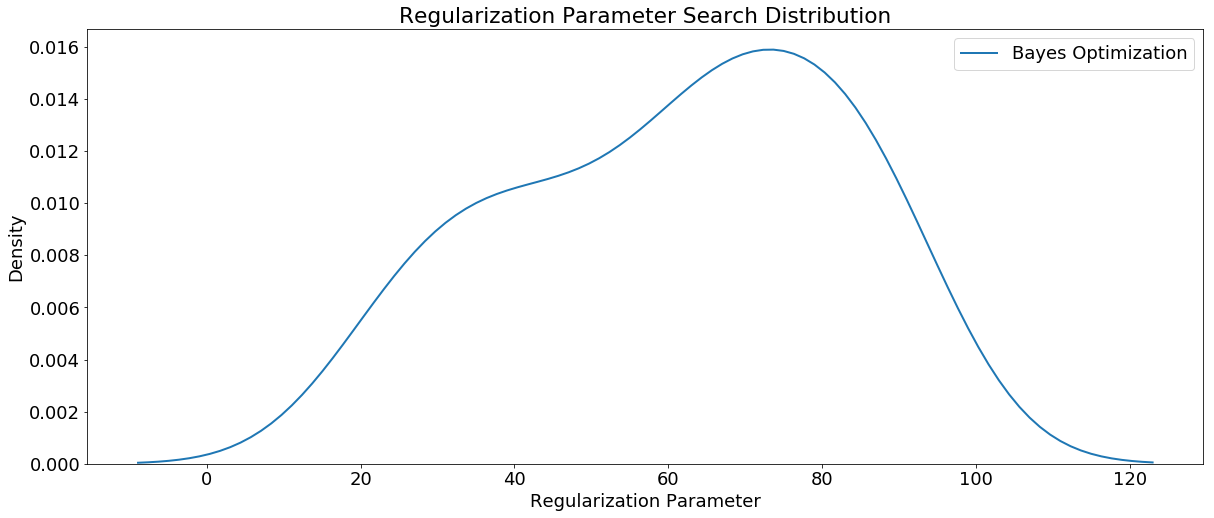

In [28]:
plt.figure(figsize = (20, 8))
plt.rcParams['font.size'] = 18

# Density plots of the learning rate distributions 
sns.kdeplot(bayes_params['reg'], label = 'Bayes Optimization', linewidth = 2)
plt.xlabel('Regularization Parameter')
plt.ylabel('Density'); 
plt.title('Regularization Parameter Search Distribution')

Text(0.5, 1.0, 'Regularization Parameter Search Distribution')

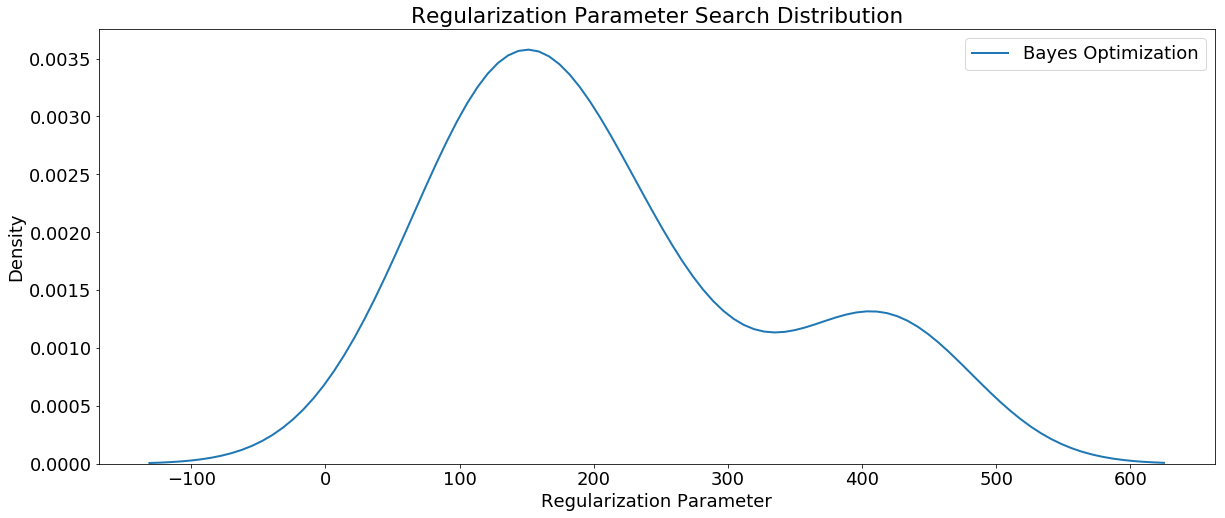

In [29]:
plt.figure(figsize = (20, 8))
plt.rcParams['font.size'] = 18

sns.kdeplot(bayes_params['iters'], label = 'Bayes Optimization', linewidth = 2)
plt.xlabel('Regularization Parameter')
plt.ylabel('Density'); 
plt.title('Regularization Parameter Search Distribution')

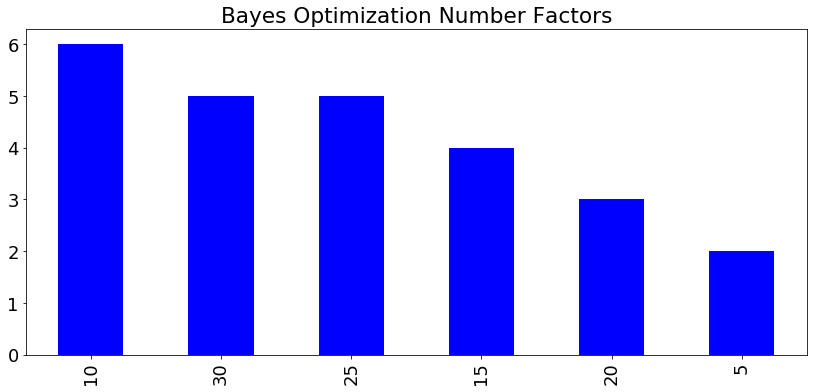

In [30]:
bayes_params['num_factors'].value_counts().plot.bar(figsize = (14, 6), 
                                                    color = 'blue', 
                                                    title = 'Bayes Optimization Number Factors')

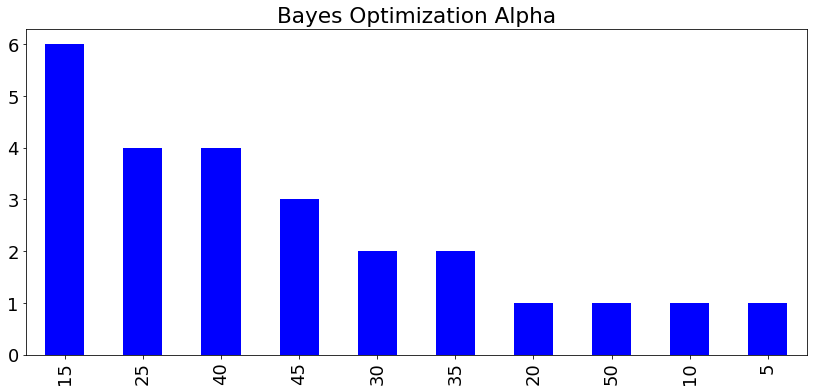

In [31]:
bayes_params['alpha'].value_counts().plot.bar(figsize = (14, 6), 
                                                    color = 'blue', 
                                                    title = 'Bayes Optimization Alpha')

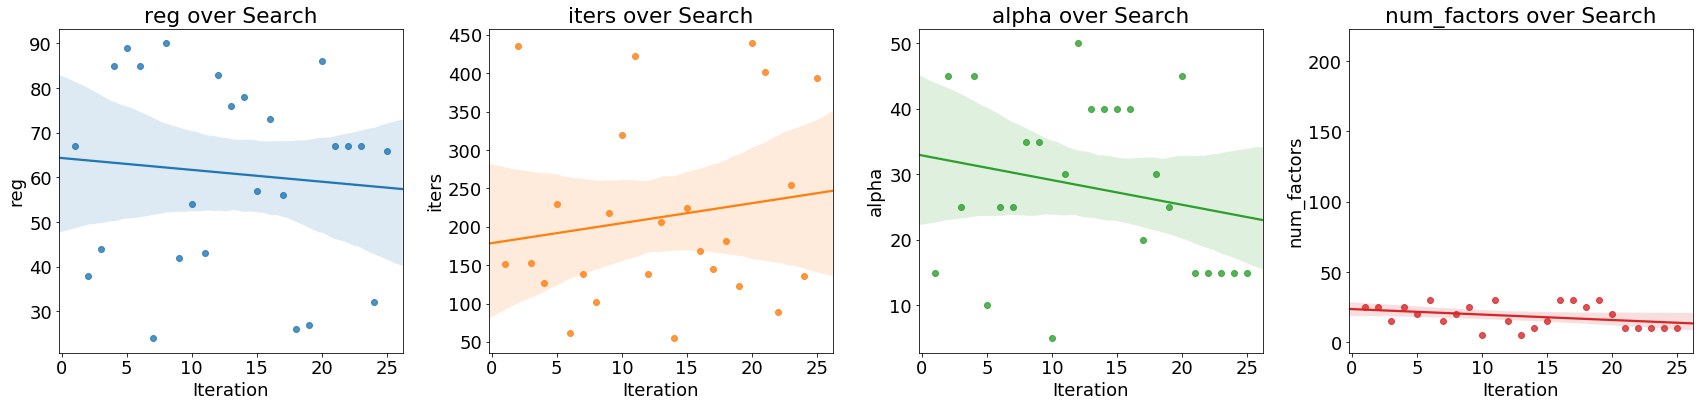

In [32]:
fig, axs = plt.subplots(1, 4, figsize = (24, 6))
i = 0

# Plot of four hyperparameters
for i, hyper in enumerate(['reg', 'iters', 'alpha', 'num_factors']):
    
        # Scatterplot
        sns.regplot('iteration', hyper, data = bayes_params, ax = axs[i])
        axs[i].set(xlabel = 'Iteration', ylabel = '{}'.format(hyper), title = '{} over Search'.format(hyper));

plt.tight_layout()

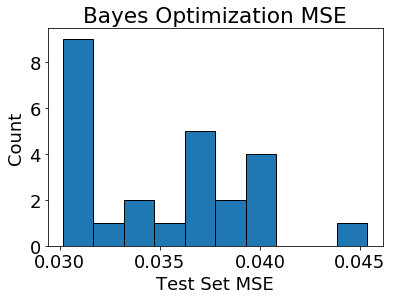

In [33]:
plt.hist(bayes_params['loss'], label = 'Bayes Optimization', edgecolor = 'k');
plt.xlabel("Test Set MSE"); plt.ylabel("Count"); plt.title("Bayes Optimization MSE");

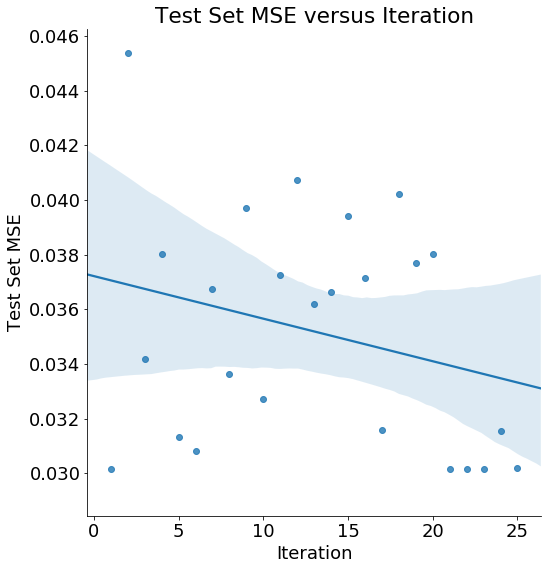

In [34]:
# Plot of scores over the course of searching
sns.lmplot('iteration', 'loss', data = bayes_params, size = 8);
plt.xlabel('Iteration'); plt.ylabel('Test Set MSE'); plt.title("Test Set MSE versus Iteration");

In [35]:
# Save dataframes of parameters
bayes_params.to_csv('./results/bayes_params.csv', index = False)

### Fit the ALS model with tuned parameters

Fit the ALS model and return the user and item vectors

In [36]:
best_model, user_vecs, item_vecs = als_model.fit_als(alpha = best_params['alpha'], 
                                                    num_factors = best_params['num_factors'], 
                                                    reg = best_params['reg'], 
                                                    iters = best_params['iters'])

### Get the MSE on the training and test sets

In [37]:
training_mse, test_set_mse = als_model.get_mse(user_vecs, item_vecs, train_df_mapped, test_df_mapped)

training set mse = 0.030075328863545348, test set mse = 0.03016013447924045


### Convert user and item vectors to DataFrame and map to CUST_CODE and PROD_CODE

In [38]:
user_factors, item_factors = als_model.get_user_item_factors(user_vecs, 
                                                             item_vecs, 
                                                             train_df_mapped, 
                                                             train_items_mapping, 
                                                             train_cust_mapping)

In [39]:
user_factors.head()

,factor_0,factor_1,factor_2,factor_3,factor_4,factor_5,factor_6,factor_7,factor_8,factor_9,CUST_CODE
0,0.010782,0.009033,0.003996,0.003694,0.000160,0.006695,0.001238,0.012827,0.011340,0.006605,CUST0000000013
1,0.139043,0.056194,-0.053882,0.073238,0.013673,0.152212,-0.029640,-0.011534,0.039995,0.040454,CUST0000000055
2,-0.002629,0.005323,0.017131,0.000844,-0.000214,0.008501,0.005609,0.005527,-0.002142,0.008460,CUST0000000679
3,-0.000887,0.002212,0.007105,-0.000859,-0.003027,0.005705,0.002838,0.001451,0.005536,0.004998,CUST0000001052
4,0.007321,0.001429,-0.002120,0.011208,0.005213,0.006015,0.002753,0.002377,0.002852,0.006513,CUST0000001058


In [40]:
item_factors.head(100)

,factor_0,factor_1,factor_2,factor_3,factor_4,factor_5,factor_6,factor_7,factor_8,factor_9,PROD_CODE
0,0.168548,0.013359,0.242663,0.319334,0.010473,0.325035,0.316355,0.093713,0.157409,0.300925,PRD0900121
1,0.034848,0.057924,-0.000043,0.110543,0.065448,0.024039,0.026003,0.074811,0.060372,0.067717,PRD0900161
2,-0.017153,0.012122,0.066921,-0.000038,0.018098,0.009732,0.048802,0.022601,0.034947,0.040015,PRD0900234
3,-0.007956,0.044255,0.002782,-0.014803,0.014389,0.008214,0.019772,0.025648,0.025386,0.006552,PRD0900330
4,0.235538,0.030606,-0.020513,0.052501,-0.010800,0.211388,0.012995,0.023282,0.035685,0.063589,PRD0900434
5,0.013922,0.040321,0.058787,0.052264,-0.066680,0.130982,0.064930,0.052475,0.164425,0.072861,PRD0900456
6,0.081908,0.020049,0.015594,0.001161,0.033228,0.177673,-0.043942,-0.003116,-0.047687,0.012633,PRD0900527
7,0.152326,0.187172,0.156096,0.072582,0.378317,0.055053,0.307687,0.273605,0.154752,0.163916,PRD0900643
8,0.015755,0.005348,0.001599,0.010140,-0.002453,0.029621,-0.001098,0.028266,0.011408,0.033544,PRD0900906
9,0.019969,0.019074,0.026473,-0.001940,0.007493,0.027335,0.010079,0.010512,0.002107,0.023571,PRD0901297


In [41]:
# Save user and item factors
item_factors.to_csv('./results/item_factors.csv', index = False)
user_factors.to_csv('./results/user_factros.csv', index = False)

### Run some ad-hoc checks on the predictions

In [64]:
# Get records for customer 0 then use the built in recommend function to look up the recommendations for that user - 
# do they make sense?

# Get customer 0
cust_0 = train_df_mapped.loc[train_df_mapped['index_CUST_CODE'] == 0].copy()

# Create a rank based on actual quantity purchased
cust_0.loc[:, "actual_rank"] = cust_0.groupby("CUST_CODE")["QUANTITY"].rank("dense", ascending=False)

recommendations = best_model.recommend(userid = 0,
                                      user_items = purchases_sparse,
                                      N = 20)

recommendations = pd.DataFrame(recommendations)
recommendations.columns = ['index_PROD_CODE', 'PRED_QUANTITY']

recommendations.loc[:, "pred_rank"] = recommendations["PRED_QUANTITY"].rank(ascending=False)

cust_0_recos = recommendations.merge(cust_0.loc[:, ["actual_rank","index_PROD_CODE"]], 
                                     on = 'index_PROD_CODE', 
                                     how = 'left')

cust_0_recos

,index_PROD_CODE,PRED_QUANTITY,pred_rank,actual_rank
0,3051,0.038682,1.0,NaN
1,3677,0.033876,2.0,NaN
2,1347,0.025336,3.0,NaN
3,829,0.024851,4.0,NaN
4,2028,0.023844,5.0,NaN
5,120,0.023634,6.0,13.0
6,172,0.022152,7.0,NaN
7,4357,0.021909,8.0,12.0
8,1264,0.021363,9.0,NaN
9,4886,0.020943,10.0,NaN


In [65]:
 # Get the predicted DataFrame from the dot product of the user and item vectors
pred_df = pd.DataFrame(user_vecs.dot(item_vecs.T))

# Get the column headers(product indices)
products = list(train_df_mapped["index_PROD_CODE"].unique())

# Replace the column indices with the product index
pred_df.columns = products

# Create a column for the index_CUST_CODE - this is the index of the DataFrame
pred_df.loc[:, "index_CUST_CODE"] = np.sort(train_df_mapped["index_CUST_CODE"].unique())

# Melt the DataFrame
pred_df_melt = pd.melt(pred_df, id_vars="index_CUST_CODE", value_vars=products)
pred_df_melt = pred_df_melt.rename(columns={"variable": "index_PROD_CODE", 
                                            "value": "PRED_QUANTITY"})

# Get the test set predicted and actual
test_pred_actual = test_df_mapped.merge(pred_df_melt, on=["index_CUST_CODE", "index_PROD_CODE"], how="inner")

# Create a column for the error in the quantity prediction
test_pred_actual.loc[:,'pred_error'] = test_pred_actual['QUANTITY'] - test_pred_actual['PRED_QUANTITY']

# Create ranks of the actual and predicted quantity by customer
test_pred_actual.loc[:, "pred_rank"] = test_pred_actual.groupby("CUST_CODE")["PRED_QUANTITY"].rank("dense", ascending=False)
test_pred_actual.loc[:, "actual_rank"] = test_pred_actual.groupby("CUST_CODE")["QUANTITY"].rank("dense", ascending=False)

# Add a column for the total number of items purchased
tot_items = test_pred_actual.groupby(["CUST_CODE"])["PROD_CODE"].count().reset_index(name="number_unique_items")
test_pred_actual = test_pred_actual.merge(tot_items, on = 'CUST_CODE')

# Create a column for the error in the rank
test_pred_actual.loc[:,"rank_error"] = test_pred_actual['actual_rank'] - test_pred_actual['pred_rank']


In [66]:
test_pred_actual.sort_values(['CUST_CODE','actual_rank']).head(100)

,CUST_CODE,PROD_CODE,QUANTITY,index_CUST_CODE,index_PROD_CODE,PRED_QUANTITY,pred_error,pred_rank,actual_rank,number_unique_items,rank_error
45461,CUST0000000013,PRD0904158,0.038846,0,4157,0.002876,0.035970,2.0,1.0,4,-1.0
45459,CUST0000000013,PRD0900139,0.010000,0,138,0.002529,0.007471,3.0,2.0,4,-1.0
45460,CUST0000000013,PRD0904311,0.010000,0,4310,0.003690,0.006310,1.0,2.0,4,1.0
45462,CUST0000000013,PRD0902860,0.010000,0,2859,0.001701,0.008299,4.0,2.0,4,-2.0
47258,CUST0000000055,PRD0901006,1.010000,1,1005,0.006834,1.003166,2.0,1.0,2,-1.0
47259,CUST0000000055,PRD0902142,0.045088,1,2141,0.018823,0.026265,1.0,2.0,2,1.0
47380,CUST0000000679,PRD0902537,0.191818,2,2536,0.000442,0.191376,1.0,1.0,2,0.0
47381,CUST0000000679,PRD0900128,0.010000,2,127,0.000067,0.009933,2.0,2.0,2,0.0
47233,CUST0000001052,PRD0903376,0.096957,3,3375,0.000376,0.096581,3.0,1.0,4,-2.0
47231,CUST0000001052,PRD0901299,0.010000,3,1298,0.000783,0.009217,1.0,2.0,4,1.0


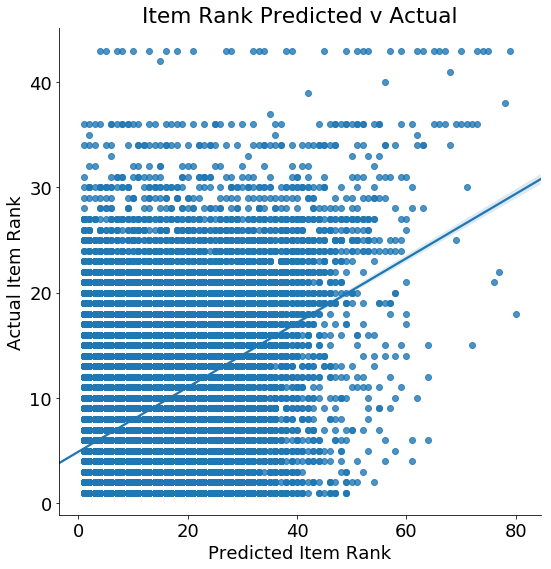

In [67]:
sns.lmplot('pred_rank', 'actual_rank', data = test_pred_actual, size = 8);
plt.xlabel('Predicted Item Rank'); plt.ylabel('Actual Item Rank'); plt.title("Item Rank Predicted v Actual");

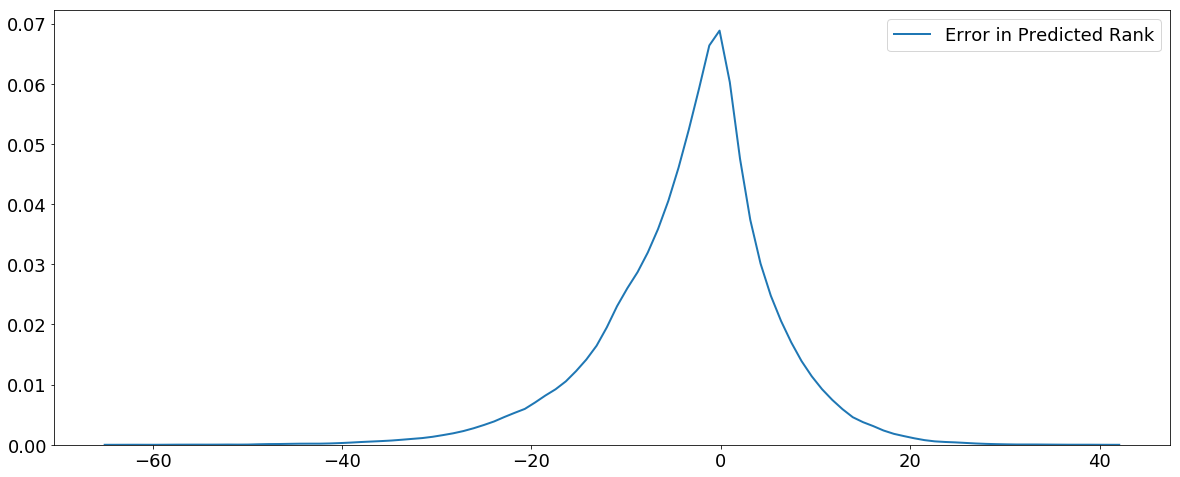

In [68]:
plt.figure(figsize = (20, 8))
sns.kdeplot(test_pred_actual['rank_error'], label = 'Error in Predicted Rank', linewidth = 2)

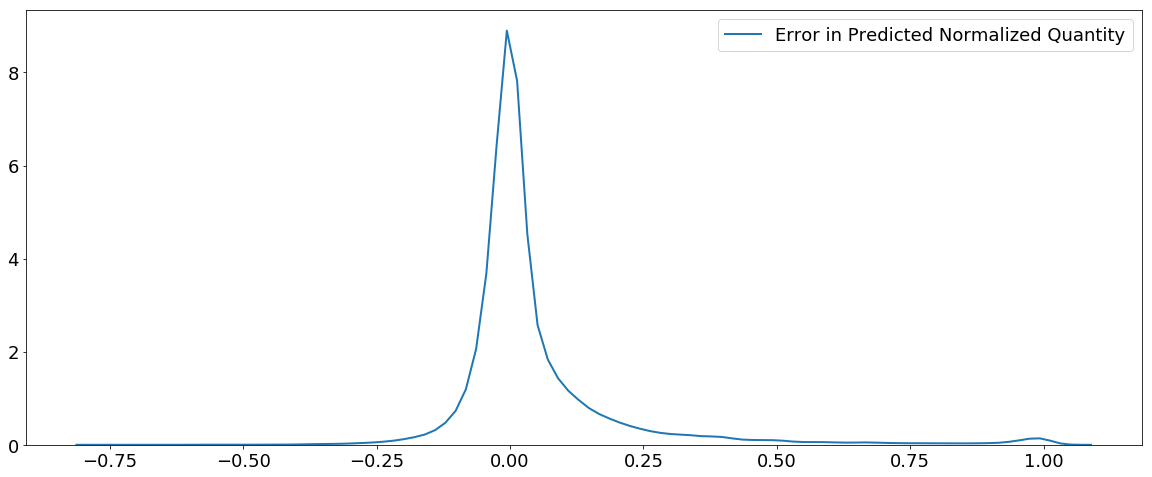

In [69]:
plt.figure(figsize = (20, 8))
sns.kdeplot(test_pred_actual['pred_error'], label = 'Error in Predicted Normalized Quantity', linewidth = 2)

In [70]:
# What was the percentage of a customers top 5 items correctly predicted for customers with 20 or more items
cust_gt_10_items = test_pred_actual[test_pred_actual['number_unique_items'] > 20]
cust_top_5 = cust_gt_10_items[cust_gt_10_items['actual_rank'] <=5]
cust_top_5 = cust_top_5.copy()
cust_top_5.loc[:,'pred_top_5'] = [1 if x <=5 else 0 for x in cust_top_5['pred_rank']] 
np.mean(cust_top_5['pred_top_5'])

0.1809693196976434